In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import numpy as np
import scipy
import h5py

In [6]:
from src.utils.logger import Logging
from src.utils.plotting_regular_2D_time_seqeunce import draw_contourf_regular_2D

from src.nn.tanh import MLP
from src.nn.tanh2 import MLP2
from src.nn.kan2 import KAN2
from src.utils.plot_losses import plot_M1_loss_history

DEVICE = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

# file_path = "/home/vlq26735/saiful/afrah/datasets/IBM/IB_PINN3.mat"

# h=  0.498715
# k=  0.6851750000000001
# rx=  0.209685
# ry=  0.21008499999999997

In [7]:
TEST_CHECKPOINT_PATH = "./checkpoints"
logger = Logging(TEST_CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()

logger.print(f"Device used {DEVICE}")

INFO:src.utils.logger:Device used cpu


### Load  and reshape the Testing Dataset if required

In [8]:
processed_dataset_path = "./data/Fluid_trainingData.mat"
Fluid_data = scipy.io.loadmat(processed_dataset_path)
data = h5py.File("data/IB_PINN3.mat", "r")  # load dataset from matlab
fluid = np.transpose(
    data["Fluid"], axes=range(len(data.get("Fluid").shape) - 1, -1, -1)
).astype(np.float32)

interface = Fluid_data["Solid_interface"]
solid = Fluid_data["Solid_points"]


In [9]:
tstep = 101
xstep = 102
ystep = 102

part = "Fluid"
N_data = xstep * ystep

steps = [tstep, xstep, ystep]
txy = [fluid[:, 0], fluid[:, 1], fluid[:, 2]]


input_interface = np.concatenate(
    [interface[:, 0:1], interface[:, 1:2], interface[:, 2:3]], axis=1
)


In [10]:
# m1_path = "./checkpoints/2025-05-02_20-18-03-014736/model.pth"
m1_path = "./checkpoints/2025-05-04_07-55-25-536831/model.pth"
m2_path = "./checkpoints/2025-05-02_20-01-28-664593/model.pth"  ## kan model

model_state_m1 = torch.load(m1_path)
model_state_m2 = torch.load(m2_path)

solver_m1 = model_state_m1["solver"]
solver_m2 = model_state_m2["solver"]

if solver_m1 == "mlp":
    fluid_model_m1 = MLP2(model_state_m1["fluid_network"]).to("cpu")
else:
    fluid_model_m1 = KAN2(model_state_m1["fluid_network"]).to("cpu")

if solver_m2 == "mlp":
    fluid_model_m2 = MLP2(model_state_m2["fluid_network"]).to("cpu")
    # solid_model_m2 = MLP2(model_state_m2["solid_network"]).to("cpu")
else:
    fluid_model_m2 = KAN2(model_state_m2["fluid_network"]).to("cpu")
    # solid_model_m2 = KAN(model_state_m2["solid_network"]).to("cpu")

plot_M1_loss_history(
    model_state_m1["loss_history"],
    os.path.join(logger.get_output_dir(), "loss_history_M1.png"),
    y_max=30,
    y_min=0,
    figsize=(12, 8),
)

plot_M1_loss_history(
    model_state_m2["loss_history"],
    os.path.join(logger.get_output_dir(), "loss_history_M2.png"),
    y_max=10,
    y_min=0,
    figsize=(12, 8),
)

fluid_model_m1.load_state_dict(model_state_m1["fluid_model_state_dict"])
fluid_model_m2.load_state_dict(model_state_m2["fluid_model_state_dict"])

# if solid_model_m2 is not None:
#     solid_model_m2.load_state_dict(model_state_m2["solid_model_state_dict"])
#     solid_model_m2.eval()

fluid_model_m1.eval()
fluid_model_m2.eval()

FileNotFoundError: [Errno 2] No such file or directory: './checkpoints/2025-05-04_07-55-25-536831/model.pth'

In [ ]:
with torch.no_grad():
    outputs_fluid_m1 = np.array(
        fluid_model_m1(
            torch.cat(
                [
                    torch.tensor(fluid[:, 0:1], dtype=torch.float32),
                    torch.tensor(fluid[:, 1:2], dtype=torch.float32),
                    torch.tensor(fluid[:, 2:3], dtype=torch.float32),
                ],
                dim=1,
            ).squeeze(1)
        )
    )
    outputs_interface_m1 = np.array(
        fluid_model_m1(
            torch.cat(
                [
                    torch.tensor(interface[:, 0:1], dtype=torch.float32),
                    torch.tensor(interface[:, 1:2], dtype=torch.float32),
                    torch.tensor(interface[:, 2:3], dtype=torch.float32),
                ],
                dim=1,
            ).squeeze(1)
        )
    )
    outputs_fluid_m2 = np.array(
        fluid_model_m2(
            torch.cat(
                [
                    torch.tensor(fluid[:, 0:1], dtype=torch.float32),
                    torch.tensor(fluid[:, 1:2], dtype=torch.float32),
                    torch.tensor(fluid[:, 2:3], dtype=torch.float32),
                ],
                dim=1,
            ).squeeze(1)
        )
    )
    outputs_interface_m2 = np.array(
        fluid_model_m2(
            torch.cat(
                [
                    torch.tensor(interface[:, 0:1], dtype=torch.float32),
                    torch.tensor(interface[:, 1:2], dtype=torch.float32),
                    torch.tensor(interface[:, 2:3], dtype=torch.float32),
                ],
                dim=1,
            ).squeeze(1)
        )
    )

u_pred_fluid_m1 = outputs_fluid_m1[:, 0:1]
v_pred_fluid_m1 = outputs_fluid_m1[:, 1:2]
p_pred_fluid_m1 = outputs_fluid_m1[:, 2:3]
u_pred_interface_m1 = outputs_interface_m1[:, 0:1]
v_pred_interface_m1 = outputs_interface_m1[:, 1:2]
p_pred_interface_m1 = outputs_interface_m1[:, 2:3]

u_pred_fluid_m2 = outputs_fluid_m2[:, 0:1]
v_pred_fluid_m2 = outputs_fluid_m2[:, 1:2]
p_pred_fluid_m2 = outputs_fluid_m2[:, 2:3]
u_pred_interface_m2 = outputs_interface_m2[:, 0:1]
v_pred_interface_m2 = outputs_interface_m2[:, 1:2]
p_pred_interface_m2 = outputs_interface_m2[:, 2:3]


In [ ]:
rel_u_l2_error = (
    np.sqrt(
        np.mean((u_pred_fluid_m1 - np.array(fluid[:, 3:4])) ** 2)
        / np.mean(np.array(fluid[:, 3:4]) ** 2)
    )
    * 100
)
rel_v_l2_error = (
    np.sqrt(
        np.mean((v_pred_fluid_m1 - np.array(fluid[:, 4:5])) ** 2)
        / np.mean(np.array(fluid[:, 4:5]) ** 2)
    )
    * 100
)
rel_p_l2_error = (
    np.sqrt(
        np.mean((p_pred_fluid_m1 - np.array(fluid[:, 5:6])) ** 2)
        / np.mean(np.array(fluid[:, 5:6]) ** 2)
    )
    * 100
)

logger.print(f"using mode : m1")
logger.print(f"Relative L2 error for u: {rel_u_l2_error:.2e} %")
logger.print(f"Relative L2 error for v: {rel_v_l2_error:.2e} %")
logger.print(f"Relative L2 error for p: {rel_p_l2_error:.2e} %")

logger.print(f"using mode : m2")

rel_u_l2_error = (
    np.sqrt(
        np.mean((u_pred_fluid_m2 - np.array(fluid[:, 3:4])) ** 2)
        / np.mean(np.array(fluid[:, 3:4]) ** 2)
    )
    * 100
)
rel_v_l2_error = (
    np.sqrt(
        np.mean((v_pred_fluid_m2 - np.array(fluid[:, 4:5])) ** 2)
        / np.mean(np.array(fluid[:, 4:5]) ** 2)
    )
    * 100
)
rel_p_l2_error = (
    np.sqrt(
        np.mean((p_pred_fluid_m2 - np.array(fluid[:, 5:6])) ** 2)
        / np.mean(np.array(fluid[:, 5:6]) ** 2)
    )
    * 100
)

logger.print(f"Relative L2 error for u: {rel_u_l2_error:.2e} %")
logger.print(f"Relative L2 error for v: {rel_v_l2_error:.2e} %")
logger.print(f"Relative L2 error for p: {rel_p_l2_error:.2e} %")


## On the interface

logger.print(f"On the interface")
rel_u_l2_error = (
    np.sqrt(
        np.mean((u_pred_interface_m1 - np.array(interface[:, 3:4])) ** 2)
        / np.mean(np.array(interface[:, 3:4]) ** 2)
    )
    * 100
)
rel_v_l2_error = (
    np.sqrt(
        np.mean((v_pred_interface_m1 - np.array(interface[:, 4:5])) ** 2)
        / np.mean(np.array(interface[:, 4:5]) ** 2)
    )
    * 100
)
rel_p_l2_error = (
    np.sqrt(
        np.mean((p_pred_interface_m1 - np.array(interface[:, 5:6])) ** 2)
        / np.mean(np.array(interface[:, 5:6]) ** 2)
    )
    * 100
)

logger.print(f"using mode : m1")
logger.print(f"Relative L2 error for u: {rel_u_l2_error:.2e} %")
logger.print(f"Relative L2 error for v: {rel_v_l2_error:.2e} %")
logger.print(f"Relative L2 error for p: {rel_p_l2_error:.2e} %")

logger.print(f"using mode : m2")

rel_u_l2_error = (
    np.sqrt(
        np.mean((u_pred_interface_m2 - np.array(interface[:, 3:4])) ** 2)
        / np.mean(np.array(interface[:, 3:4]) ** 2)
    )
    * 100
)
rel_v_l2_error = (
    np.sqrt(
        np.mean((v_pred_interface_m2 - np.array(interface[:, 4:5])) ** 2)
        / np.mean(np.array(interface[:, 4:5]) ** 2)
    )
    * 100
)
rel_p_l2_error = (
    np.sqrt(
        np.mean((p_pred_interface_m2 - np.array(interface[:, 5:6])) ** 2)
        / np.mean(np.array(interface[:, 5:6]) ** 2)
    )
    * 100
)

logger.print(f"Relative L2 error for u: {rel_u_l2_error:.2e} %")
logger.print(f"Relative L2 error for v: {rel_v_l2_error:.2e} %")
logger.print(f"Relative L2 error for p: {rel_p_l2_error:.2e} %")


INFO:src.utils.logger:using mode : m1
INFO:src.utils.logger:Relative L2 error for u: 1.32e+01 %
INFO:src.utils.logger:Relative L2 error for v: 2.06e+01 %
INFO:src.utils.logger:Relative L2 error for p: 3.05e+01 %
INFO:src.utils.logger:using mode : m2
INFO:src.utils.logger:Relative L2 error for u: 1.14e+01 %
INFO:src.utils.logger:Relative L2 error for v: 1.71e+01 %
INFO:src.utils.logger:Relative L2 error for p: 3.44e+01 %
INFO:src.utils.logger:On the interface
INFO:src.utils.logger:using mode : m1
INFO:src.utils.logger:Relative L2 error for u: 6.01e+00 %
INFO:src.utils.logger:Relative L2 error for v: 7.08e+00 %
INFO:src.utils.logger:Relative L2 error for p: 2.93e+01 %
INFO:src.utils.logger:using mode : m2
INFO:src.utils.logger:Relative L2 error for u: 2.39e+00 %
INFO:src.utils.logger:Relative L2 error for v: 3.21e+00 %
INFO:src.utils.logger:Relative L2 error for p: 1.67e+01 %


## Draw U velocity predictions for all Models

In [ ]:
#  t = tf.reshape(tstep,N_data)[:,0].T

fluid_time = np.array(fluid[:, 0:1]).reshape(tstep, xstep, ystep)[:, 0, 0]
fluid_x = np.array(fluid[:, 1:2]).reshape(tstep, xstep, ystep)[
    0, :, 0
]  # .reshape(100,100)[0,:]
fluid_y = np.array(fluid[:, 2:3]).reshape(tstep, xstep, ystep)[
    0, 0, :
]  # .reshape(100,100)[:,0]
u_fluid_cfd = np.array(fluid[:, 3]).reshape(tstep, xstep, ystep).transpose((0, 2, 1))
u_pred_fluid_m1_rshp = u_pred_fluid_m1.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
u_pred_fluid_m2_rshp = u_pred_fluid_m2.reshape(tstep, xstep, ystep).transpose((0, 2, 1))

fluid_data = [u_pred_fluid_m1_rshp] * 6 + [u_pred_fluid_m2_rshp] * 6 + [u_fluid_cfd] * 6

nrows_ncols = (3, 6)
time_steps = [0, 10, 50, 60, 80, 90] * 3
file_name = os.path.join(model_dirname, "all_models_u.png")

result = draw_contourf_regular_2D(
    fluid_time,
    fluid_x,
    fluid_y,
    fluid_data,
    nrows_ncols,
    time_steps,
    file_name,
    img_width=35,
    img_height=32,
    axes_pad=2.0,
    fontsize=20,
)

## Draw V velocity predictions for all Models

In [ ]:
v_fluid_cfd = np.array(fluid[:, 4]).reshape(tstep, xstep, ystep).transpose((0, 2, 1))
v_pred_fluid_m1_rshp = v_pred_fluid_m1.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
v_pred_fluid_m2_rshp = v_pred_fluid_m2.reshape(tstep, xstep, ystep).transpose((0, 2, 1))

fluid_data = [v_pred_fluid_m1_rshp] * 6 + [v_pred_fluid_m2_rshp] * 6 + [v_fluid_cfd] * 6

grid_shape = (3, 6)
time_steps = [0, 10, 50, 60, 80, 90] * 3
file_name = os.path.join(model_dirname, "all_models_v.png")

result = draw_contourf_regular_2D(
    fluid_time,
    fluid_x,
    fluid_y,
    fluid_data,
    grid_shape,
    time_steps,
    file_name,
    img_width=35,
    img_height=32,
    axes_pad=2.0,
    fontsize=27,
)

## Pressure field prediction comparison for all models

In [ ]:
p_fluid_cfd = np.array(fluid[:, 5]).reshape(tstep, xstep, ystep).transpose((0, 2, 1))
p_fluid_pred_m1_rshp = p_pred_fluid_m1.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
p_fluid_pred_m2_rshp = p_pred_fluid_m2.reshape(tstep, xstep, ystep).transpose((0, 2, 1))


# Compile fluid data with replicated entries
fluid_data = [p_fluid_pred_m1_rshp] * 6 + [p_fluid_pred_m2_rshp] * 6 + [p_fluid_cfd] * 6

# Define grid shape and time steps
grid_shape = (3, 6)
time_steps = [0, 10, 50, 60, 80, 90] * 3

# Execute plotting function
file_name = os.path.join(model_dirname, "all_models_p.png")

result = draw_contourf_regular_2D(
    fluid_time,
    fluid_x,
    fluid_y,
    fluid_data,
    grid_shape,
    time_steps,
    file_name,
    img_width=35,
    img_height=32,
    axes_pad=2.0,
    fontsize=27,
)

## Animation

In [ ]:
np.sqrt(u_pred_fluid_m2**2 + v_pred_fluid_m2**2).shape

(1050804, 1)

In [ ]:
import os
import pandas as pd
import numpy as np
from src.utils.fsi_visualization import (
    create_frames,
    create_animations_from_existing_frames,
)

animations_pred_dir = os.path.join(logger.get_output_dir(), "animations_pred")
animations_reference_dir = os.path.join(logger.get_output_dir(), "animations_reference")
time = fluid[:, 0]
x = fluid[:, 1]
y = fluid[:, 2]
p_cfd = fluid[:, 5]
u_cfd = fluid[:, 3]
v_cfd = fluid[:, 4]

prediction_df = pd.DataFrame(
    {
        "time": time,
        "x": x,
        "y": y,
        "pressure": p_pred_fluid_m2.flatten(),
        "u_x": u_pred_fluid_m2.flatten(),
        "v_y": v_pred_fluid_m2.flatten(),
        "velocity_magnitude": np.sqrt(
            u_pred_fluid_m2**2 + v_pred_fluid_m2**2
        ).flatten(),
    }
)
reference_df = pd.DataFrame(
    {
        "time": time,
        "x": x,
        "y": y,
        "pressure": p_cfd,
        "u_x": u_cfd,
        "v_y": v_cfd,
        "velocity_magnitude": np.sqrt(u_cfd**2 + v_cfd**2),
    }
)

create_frames(prediction_df, output_dir=animations_pred_dir, sample_rate=2)

create_animations_from_existing_frames(
    frames_dirs=[
        os.path.join(animations_pred_dir, "pressure"),
        os.path.join(animations_pred_dir, "u_x"),
        os.path.join(animations_pred_dir, "v_y"),
        os.path.join(animations_pred_dir, "velocity_magnitude"),
    ],
    output_dir=os.path.join(animations_pred_dir, "gif"),
)

create_frames(reference_df, output_dir=animations_reference_dir, sample_rate=2)

create_animations_from_existing_frames(
    frames_dirs=[
        os.path.join(animations_reference_dir, "pressure"),
        os.path.join(animations_reference_dir, "u_x"),
        os.path.join(animations_reference_dir, "v_y"),
        os.path.join(animations_reference_dir, "velocity_magnitude"),
    ],
    output_dir=os.path.join(animations_reference_dir, "gif"),
)


  Processing time step 0.00 (1/51)
  Processing time step 0.02 (2/51)
  Processing time step 0.04 (3/51)
  Processing time step 0.06 (4/51)
  Processing time step 0.08 (5/51)
  Processing time step 0.10 (6/51)
  Processing time step 0.12 (7/51)
  Processing time step 0.14 (8/51)
  Processing time step 0.16 (9/51)
  Processing time step 0.18 (10/51)
  Processing time step 0.20 (11/51)
  Processing time step 0.22 (12/51)
  Processing time step 0.24 (13/51)
  Processing time step 0.26 (14/51)
  Processing time step 0.28 (15/51)
  Processing time step 0.30 (16/51)
  Processing time step 0.32 (17/51)
  Processing time step 0.34 (18/51)
  Processing time step 0.36 (19/51)
  Processing time step 0.38 (20/51)
  Processing time step 0.40 (21/51)
  Processing time step 0.42 (22/51)
  Processing time step 0.44 (23/51)
  Processing time step 0.46 (24/51)
  Processing time step 0.48 (25/51)
  Processing time step 0.50 (26/51)
  Processing time step 0.52 (27/51)
  Processing time step 0.54 (28/51)
 

## Drawing the line plot for all models

In [ ]:
u_pred_fluid_m1_rshp[:, 0, :][0, :].shape

(102,)

In [ ]:
u_velocity_data = {
    "u": [u_pred_fluid_m1_rshp, u_pred_fluid_m2_rshp, u_fluid_cfd],
    "v": [v_pred_fluid_m1_rshp, v_pred_fluid_m2_rshp, v_fluid_cfd],
    "p": [p_fluid_pred_m1_rshp, p_fluid_pred_m2_rshp, p_fluid_cfd],
}

models = ["M2", "M4", "Exact"]

data_labels = ["u", "v", "p"]  # Variables to plot


# Indices for time steps and y locations
timeStp = [20, 50, 65, 100]  # Indices of time values to plot
yStep = [70, 65, 90, 98]  # Indices of y values to plot

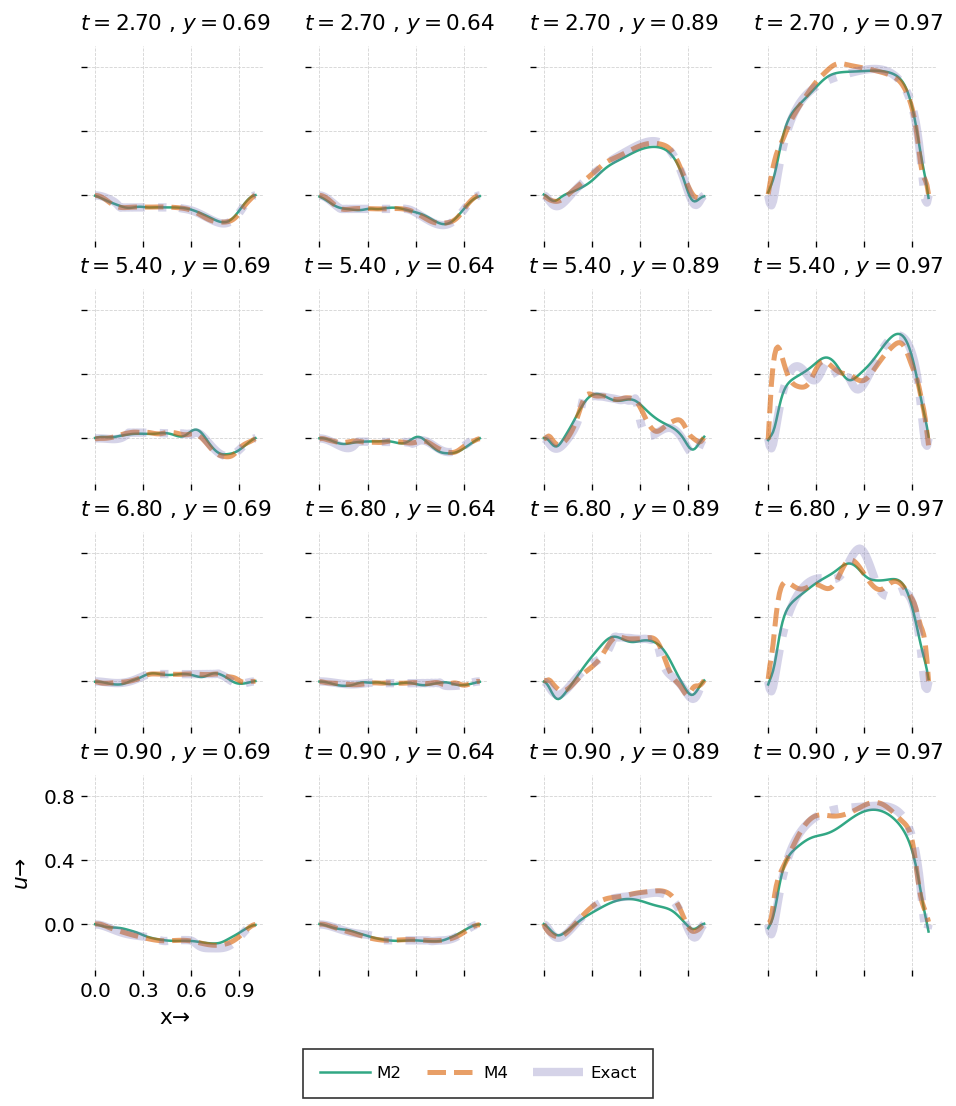

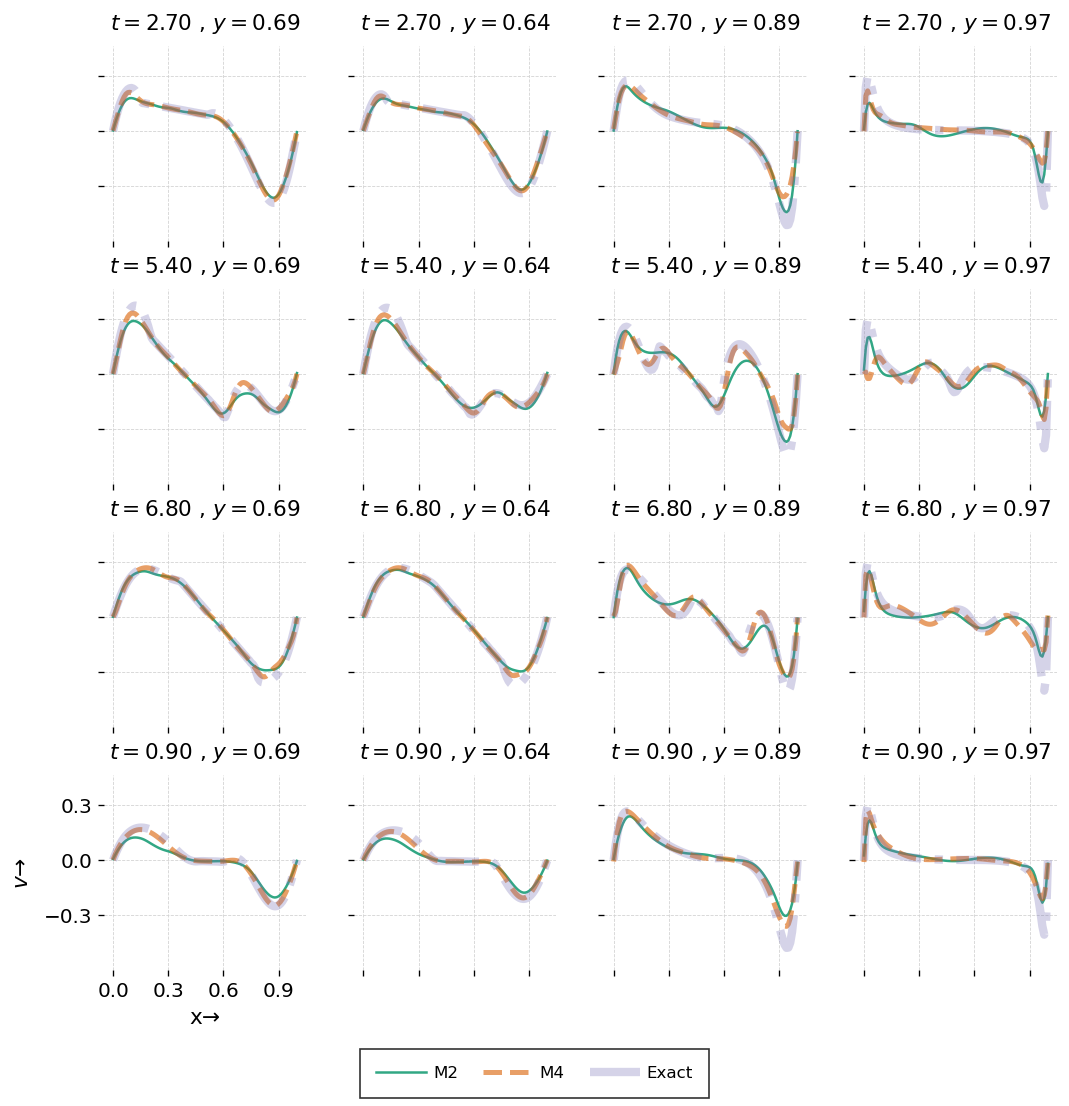

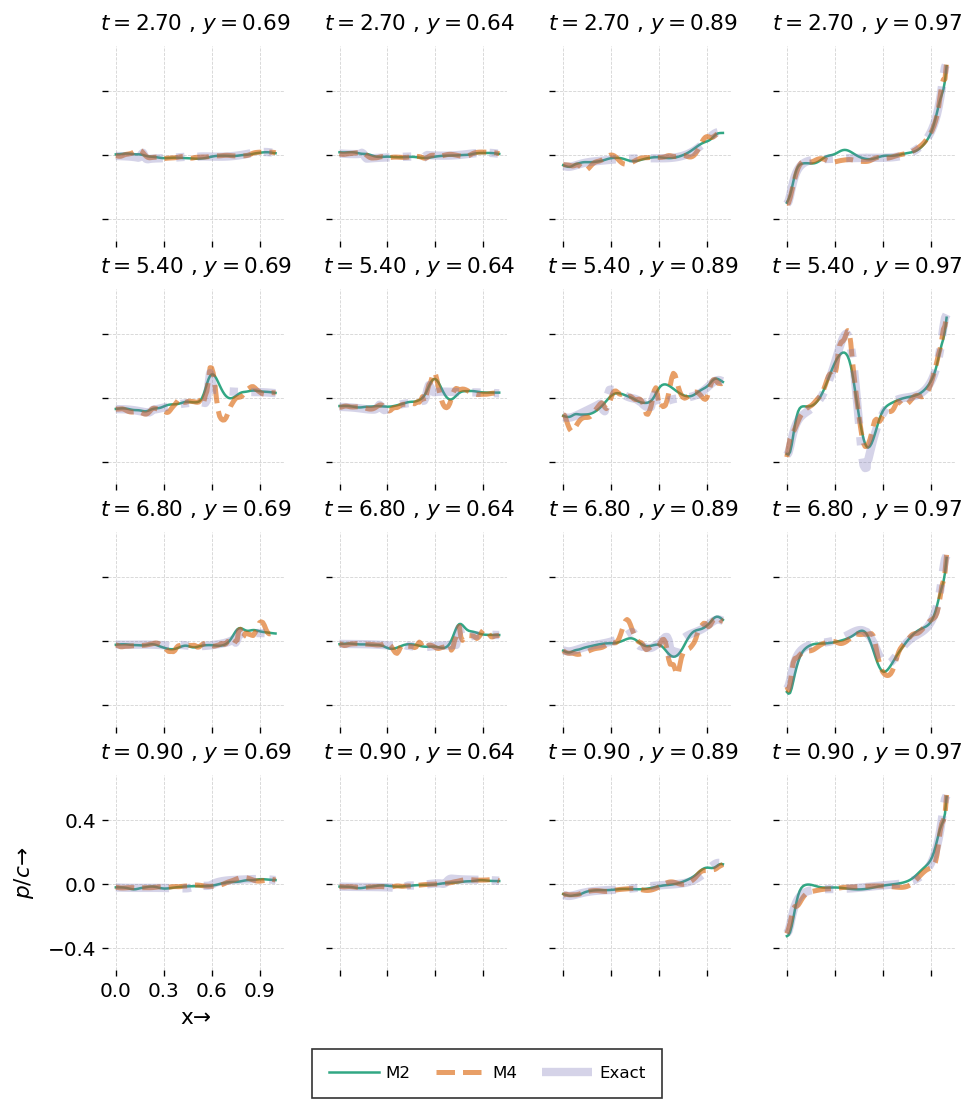

In [ ]:
from src.utils.line_plot2 import enhanced_line_plot

# Call the enhanced plotting function
enhanced_line_plot(
    fluid_time,
    fluid_x,
    fluid_y,
    u_velocity_data,
    models,
    data_labels,
    timeStp,
    yStep,
    model_dirname,
    fontsize=13,
    labelsize=12,
)